In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
parser.add_argument('--gravimetry_folder', default='Datos_Gravimetria_Anomalia_Residual', type=str, help='Folder path to gravimetry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")
gravimetry_path = os.path.join(args.data_folder, args.gravimetry_folder, "Puntos_Grilla_Anomalia_Residual_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)
df_gravimetry = pd.read_excel(gravimetry_path)

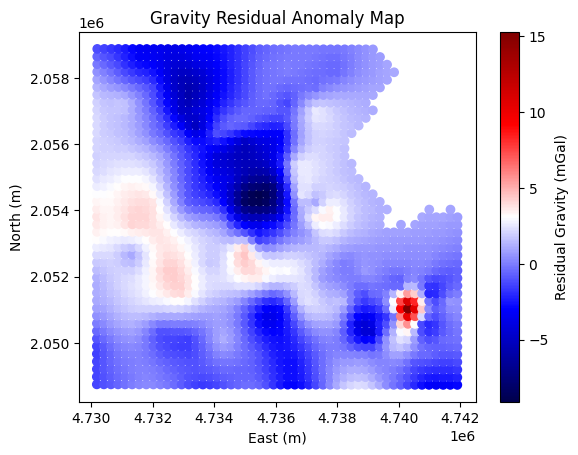

In [3]:
## Visualization
# Scatter plot of residual gravity anomaly
plt.scatter(df_gravimetry["Este"], df_gravimetry["Norte"], c=df_gravimetry["Anomalia_Residual"], cmap="seismic")
plt.colorbar(label="Residual Gravity (mGal)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Gravity Residual Anomaly Map")
plt.show()

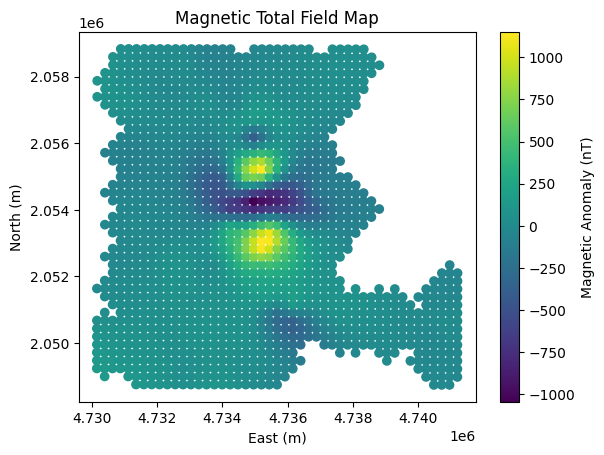

In [4]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [5]:
# Coordinates and values
x_grav = df_gravimetry["Este"].values
y_grav = df_gravimetry["Norte"].values
z_grav = df_gravimetry["Anomalia_Residual"].values

x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_gravm1, grid_y_gravm1 = np.mgrid[x_grav.min():x_grav.max():200j, y_grav.min():y_grav.max():200j]
grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [6]:
# numpy matrix
coords_grav = np.stack([x_grav, y_grav], axis=1).astype(np.float32)   # [N, 2]
targets_grav = z_grav.astype(np.float32).reshape(-1, 1)               # [N, 1]

targets_grav_max = np.max(targets_grav)   
targets_grav_min = np.min(targets_grav)           

coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   

# 2) Normalizer
norm_grav = MinMaxNormalizer().fit(coords_grav, targets_grav)
Xg_n, Yg_n = norm_grav.transform(coords_grav, targets_grav)

# 3) Normalizer
norm_magn = MinMaxNormalizer().fit(coords_magn, targets_magn)
Xm_n, Ym_n = norm_magn.transform(coords_magn, targets_magn)

# 4) DataLoaders
ds_grav = TensorDataset(torch.from_numpy(Xg_n), torch.from_numpy(Yg_n))
ds_magn = TensorDataset(torch.from_numpy(Xm_n), torch.from_numpy(Ym_n))

dl_grav = DataLoader(ds_grav, batch_size=256, shuffle=True)
dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [7]:
# Simple train/val split using a random permutation
def train_val_split(dataset, val_ratio=0.2, seed=42):
    n = len(dataset)
    idx = torch.randperm(n, generator=torch.Generator().manual_seed(seed))
    n_val = int(n * val_ratio)
    val_idx, train_idx = idx[:n_val], idx[n_val:]
    train_subset = torch.utils.data.Subset(dataset, train_idx.tolist())
    val_subset = torch.utils.data.Subset(dataset, val_idx.tolist())
    return train_subset, val_subset

train_grav, val_grav = train_val_split(ds_grav, val_ratio=0.2)
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

# Create DataLoaders
batch_size = 256
dl_grav_train = DataLoader(train_grav, batch_size=batch_size, shuffle=True, num_workers=0)
dl_grav_val   = DataLoader(val_grav,   batch_size=batch_size, shuffle=False, num_workers=0)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
###### Training
model_wire = CMLP(
    in_features=2, out_features=1,
    hidden_layers=5, hidden_units=512,
    activation='wire', wire_omega=1.0, wire_sigma=1.0  # synthetic-like defaults
)

optimizer = torch.optim.Adam(model_wire.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-4,
    steps_per_epoch=len(dl_grav),
    epochs=100
)

loss = []

epochs = 1000

for epoch in range(epochs):
    for batch_magn in dl_magn:
        optimizer.zero_grad()
        coords_magn, target_magn = batch_magn
        pred_magn = model_wire(coords_magn)

        loss = criterion(pred_magn,target_magn)
        loss.backward()
        optimizer.step()

    torch.save(model_wire.state_dict(), 'checkpoints/model_wire.pth')
    print("Epoch: ", epoch, " Loss: ", loss.item())
        


Epoch:  0  Loss:  2.598235607147217
Epoch:  1  Loss:  0.6809355020523071
Epoch:  2  Loss:  0.02415347285568714
Epoch:  3  Loss:  0.14302818477153778
Epoch:  4  Loss:  0.38974159955978394
Epoch:  5  Loss:  0.3749130666255951
Epoch:  6  Loss:  0.19976806640625
Epoch:  7  Loss:  0.05667649954557419
Epoch:  8  Loss:  0.005520194303244352
Epoch:  9  Loss:  0.03655682131648064
Epoch:  10  Loss:  0.07666175812482834
Epoch:  11  Loss:  0.06407896429300308
Epoch:  12  Loss:  0.03230782970786095
Epoch:  13  Loss:  0.012199899181723595
Epoch:  14  Loss:  0.008874895982444286
Epoch:  15  Loss:  0.016958974301815033
Epoch:  16  Loss:  0.021248923614621162
Epoch:  17  Loss:  0.019488153979182243
Epoch:  18  Loss:  0.010655270889401436
Epoch:  19  Loss:  0.009083879180252552
Epoch:  20  Loss:  0.009437528438866138
Epoch:  21  Loss:  0.006287215277552605
Epoch:  22  Loss:  0.006940929219126701
Epoch:  23  Loss:  0.00562433572486043
Epoch:  24  Loss:  0.006761332508176565
Epoch:  25  Loss:  0.006751515

In [ ]:
for batch_magn in dl_magn:
    coords_magn, target_magn = batch_magn
    
    model_wire.eval()
    pred_magn = model_wire(coords_magn)
    print(coords_magn[0], target_magn[0].item(), pred_magn[0].item())
    break

tensor([0.2556, 0.7273]) 0.2810531556606293 0.35381484031677246
